In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
print(tf.__version__)

2.5.0


In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 1s 0us/step


In [4]:
os.listdir(dataset_dir)

['train', 'imdbEr.txt', 'README', 'imdb.vocab', 'test']

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_neg.txt',
 'unsupBow.feat',
 'unsup',
 'pos',
 'neg',
 'urls_unsup.txt',
 'labeledBow.feat',
 'urls_pos.txt']

In [6]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [7]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [28]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [29]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [30]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [31]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [32]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size, 
   )

Found 25000 files belonging to 2 classes.


In [33]:
def custom_standardization(input_data):
  lc = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lc,'<be />',' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]'%re.escape(string.punctuation),
                                  '')

In [34]:
max_features = 10000
seq_len = 250
vect_layer = TextVectorization(
    standardize = custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=seq_len)

In [35]:
train_text = raw_train_ds.map(lambda x,y:x)
vect_layer.adapt(train_text)

In [38]:
def vect_text(text,label):
  text = tf.expand_dims(text,-1)
  return vect_layer(text), label

In [39]:
tex_batch, label_batch = next(iter(raw_train_ds))
first_review,first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vect_text(first_review,first_label))

Review tf.Tensor(b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   1,    7,    4,  194,   18, 2941,   12,  256,  127,   51,  384,
          71,  167,  257,   70,   52,   10,  361, 

In [42]:
print("1287 ---> ",vect_layer.get_vocabulary()[1287])
print(" 313 ---> ",vect_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vect_layer.get_vocabulary())))

1287 --->  naked
 313 --->  night
Vocabulary size: 10000


In [43]:
train_ds = raw_train_ds.map(vect_text)
val_ds = raw_val_ds.map(vect_text)
test_ds = raw_test_ds.map(vect_text)

In [44]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [45]:
embedding_dim = 16

In [47]:
model = tf.keras.Sequential([
                             layers.Embedding(max_features+1,embedding_dim),
                             layers.Dropout(0.2),
                             layers.GlobalAveragePooling1D(),
                             layers.Dropout(0.2),
                             layers.Dense(1)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [51]:
epochs = 10
history =model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 13s 19ms/step - loss: 0.6633 - binary_accuracy: 0.6882 - val_loss: 0.6138 - val_binary_accuracy: 0.7734
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 0.5485 - binary_accuracy: 0.8012 - val_loss: 0.4989 - val_binary_accuracy: 0.8210
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 0.4460 - binary_accuracy: 0.8430 - val_loss: 0.4220 - val_binary_accuracy: 0.8472
Epoch 4/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3803 - binary_accuracy: 0.8640 - val_loss: 0.3763 - val_binary_accuracy: 0.8604
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3379 - binary_accuracy: 0.8784 - val_loss: 0.3478 - val_binary_accuracy: 0.8660
Epoch 6/10
625/625 [==============================] - 5s 7ms/step - loss: 0.3074 - binary_accuracy: 0.8877 - val_loss: 0.3288 - val_binary_accuracy: 0.8714
Epoch 7/10
625/625 [==============================] - 5s 7ms/s

In [53]:
loss,accuracy = model.evaluate(test_ds)
print("Loss",loss)
print("Accuracy",accuracy)

782/782 [==============================] - 9s 12ms/step - loss: 0.3127 - binary_accuracy: 0.8715
Loss 0.31269100308418274
Accuracy 0.8714799880981445


In [54]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [55]:
history_dict['loss']

[0.6632519960403442,
 0.5484887361526489,
 0.44601356983184814,
 0.3803294003009796,
 0.3378685712814331,
 0.3074498176574707,
 0.2834811508655548,
 0.2641753554344177,
 0.24816054105758667,
 0.23344138264656067]

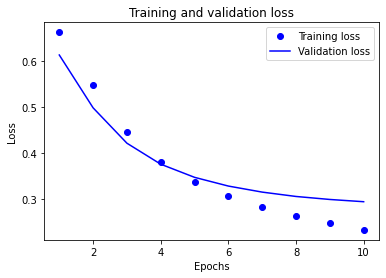

In [56]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(acc)+1)
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

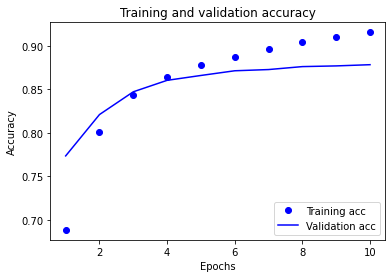

In [57]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [59]:
export_model = tf.keras.Sequential([
  vect_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 10s 12ms/step - loss: 0.3127 - accuracy: 0.8715
0.8714799880981445


In [60]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.6500801 ],
       [0.47987768],
       [0.39158487]], dtype=float32)